In [1]:
# import packages
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import re
from sklearn.externals import joblib 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import interpn
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/opt/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Editor settings
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data
sales_means =pd.read_csv('../data/sales_means_all.csv', sep='|') # .drop(columns=["predicted_promotion"])
scaler = joblib.load('./scaler.pkl') 
# df_test = pd.read_csv('../data/orders0206_test.csv', sep='|', parse_dates=['time'])
# df_test['date'] = [d.date() for d in df_test['time']]
df_train = pd.read_csv('../data/orders.csv', sep='|', parse_dates=['time'])
df_train['date'] = [d.date() for d in df_train['time']]
bundles = pd.read_csv('../data/bundles.csv', sep=',')
sales_means = sales_means.join(bundles.set_index("itemID"), on="itemID", how="left")

In [4]:
sales_means.columns

Index(['count', 'predicted_promotion', 'weekGroup', 'itemID', 'customerRating',
       'manufacturer', 'brand', 'category1', 'category3', 'dateFirstSell',
       'soldWeekly', 'recentlySold', 'count_lag_1', 'avg_salesPrice_lag_1',
       'brand_avg_avg_salesPrice_lag_1', 'brand_sum_count_lag_1',
       'brand_avg_count_lag_1', 'category1_avg_avg_salesPrice_lag_1',
       'category1_sum_count_lag_1', 'category1_avg_count_lag_1',
       'category3_avg_avg_salesPrice_lag_1', 'category3_sum_count_lag_1',
       'category3_avg_count_lag_1', 'count_lag_2', 'avg_salesPrice_lag_2',
       'brand_avg_avg_salesPrice_lag_2', 'brand_sum_count_lag_2',
       'brand_avg_count_lag_2', 'category1_avg_avg_salesPrice_lag_2',
       'category1_sum_count_lag_2', 'category1_avg_count_lag_2',
       'category3_avg_avg_salesPrice_lag_2', 'category3_sum_count_lag_2',
       'category3_avg_count_lag_2', 'count_lag_3', 'avg_salesPrice_lag_3',
       'brand_avg_avg_salesPrice_lag_3', 'brand_sum_count_lag_3',
   

In [5]:
# slit training, parameter tuning and test data
sales_means.sample(frac=1).reset_index(drop=True)
X_train = sales_means[sales_means['weekGroup'] != 13].tail(len(sales_means)-2000)#[(sales_means['weekGroup']<=9)]# & (sales_means['weekGroup']==10)]
X_cv =  sales_means[sales_means['weekGroup'] != 13].head(2000)#[sales_means['weekGroup']==10]
X_test = sales_means[sales_means['weekGroup']==13]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['weekGroup']
del X_cv['weekGroup']
del X_test['weekGroup']
del X_train['itemID']
del X_cv['itemID']

In [6]:
# use best parameters foudn through experiments
bestparams = {'n_estimators': 215,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': True}

In [7]:
# train model with best parameter combination that was found above
rf = RandomForestRegressor(**bestparams).fit(X_train.fillna(0), Y_train)

<BarContainer object of 66 artists>

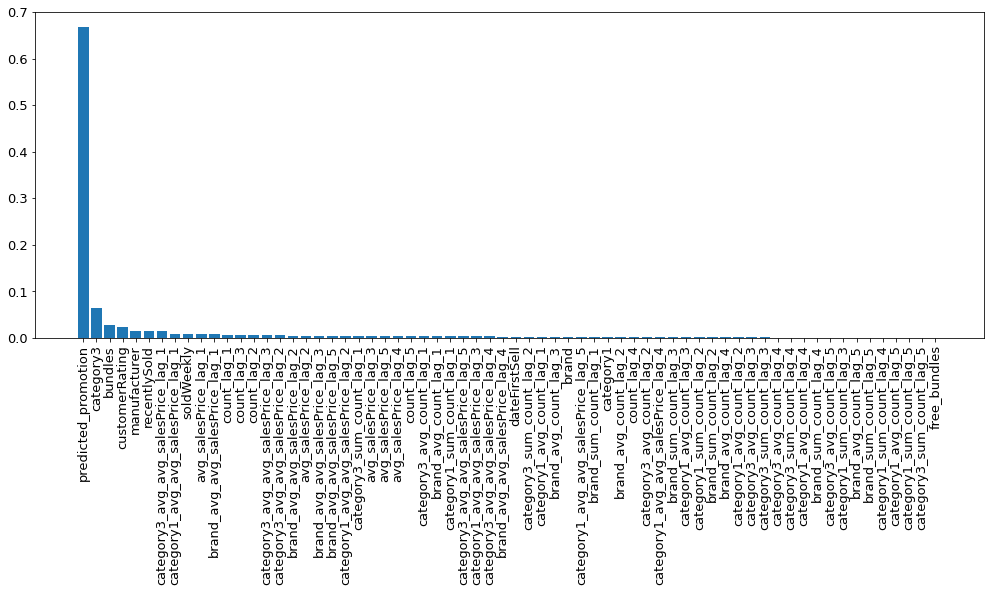

In [8]:
plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 13})
columns = X_train.columns
feature_importances = pd.DataFrame({'columns': columns,'importance':rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance',ascending=False)
plt.xticks(rotation=90)
plt.bar(feature_importances["columns"],feature_importances.importance)# ,x='columns',y='importance')

In [9]:
# apply to unseen data
y_randomforest_all = dict()

for prod in X_test.itemID.unique():
    y_randomforest_all[prod] = int(pd.DataFrame(scaler.inverse_transform(pd.DataFrame(rf.predict(X_test[X_test.itemID == prod].drop(columns=["itemID"]).fillna(0))))).sum().round())

In [12]:
pd.DataFrame(y_randomforest_all.items()).rename(columns={0:'itemID', 1:"demandPrediction"}).to_csv('abraca-data_dmc-predictions.csv',index=False, sep='|')

In [13]:
joblib.dump(rf, 'randomforest_dmc.pkl')

['randomforest_dmc.pkl']